### Import common package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR

pd.set_option('display.max_columns', None)

### import and read data

In [2]:
df = pd.read_csv("New folder (5)\excel2.csv")
df.head() 

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

### Data spliting

In [4]:
X = df[["battery_power", "clock_speed", "int_memory", "ram", "blue", "dual_sim","three_g","four_g"]]
y = df["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 8), (400, 8), (1600,), (400,))

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

#### KNN Classifiers

In [6]:
numerical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(2))
])

categorical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ["battery_power", "clock_speed", "int_memory", "ram"]),
    ('categoric', categorical_pipeline, ["blue", "dual_sim","three_g","four_g"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

params = {
    'algo__n_neighbors': np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
    'algo__weights': ['uniform', 'distance'],
    'algo__p': [1, 1.5, 2]
}

model = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 29, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.6743739650015342 0.7125


#### Random Forest Clasifiers

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
numerical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(2))
])

categorical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ["battery_power", "clock_speed", "int_memory", "ram"]),
    ('categoric', categorical_pipeline, ["blue", "dual_sim","three_g","four_g"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

params = {
    'algo__n_estimators': [100, 150, 200],
    'algo__max_depth': [20, 50, 80],
    'algo__max_features': [0.3, 0.6, 0.8],
    'algo__min_samples_leaf': [1, 5, 10]
}

model = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 150}
0.87 0.8300107979472188 0.7875


### Evaluation model

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [10]:
rf = RandomForestClassifier(max_depth= 20, max_features= .8, min_samples_leaf= 10, n_estimators= 150)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=0.8, min_samples_leaf=10,
                       n_estimators=150)

In [11]:
y_pred = rf.predict(X_test)

#### Clasification report 

In [12]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.92      0.92      0.92       105\n           1       0.76      0.74      0.75        91\n           2       0.64      0.76      0.70        92\n           3       0.91      0.79      0.84       112\n\n    accuracy                           0.81       400\n   macro avg       0.81      0.80      0.80       400\nweighted avg       0.82      0.81      0.81       400\n'

#### Confution matrix plot

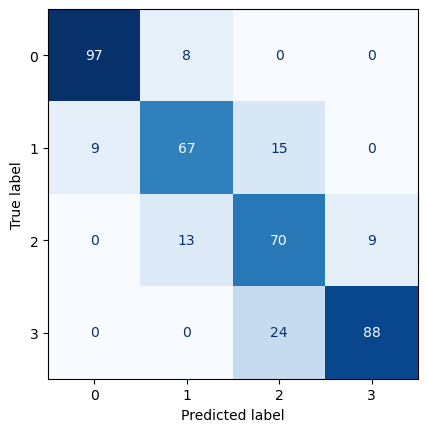

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',colorbar=False)

In [14]:
df["price_range"].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

#### Features importance

Text(0, 0.5, 'Features Name')

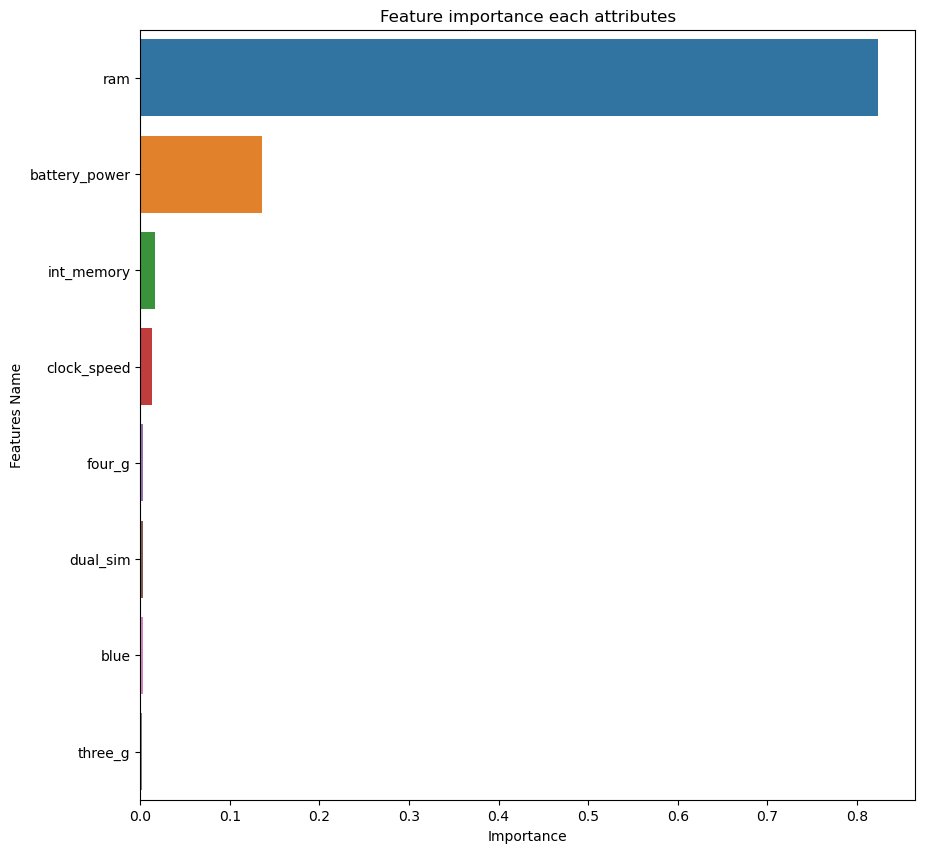

In [15]:
import seaborn as sns

imp_df = pd.DataFrame({
    'Features Name': X_train.columns,
    'Importance': rf.feature_importances_
})

f1 = imp_df.sort_values(by='Importance', ascending=False)
f12 = f1.head(10)

plt.figure(figsize=(10,10))
sns.barplot(data=f12, x='Importance', y='Features Name')
plt.title('Feature importance each attributes')
plt.xlabel('Importance')
plt.ylabel('Features Name')

#### Save model 

In [17]:
from jcopml.utils import save_model

save_model(model.best_estimator_, "RF_model.pkl")

Model is pickled as model/RF_model.pkl
